In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp

import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import itertools
import pickle
import os
import json

from aux import *
from utils.paths import *


In [2]:
loaded_data = read_pickle_files_from_directory(DATA_DIR)
# sorted_loaded_data = dict(
#     sorted(
#         loaded_data.items(),
#         key=lambda item: tuple(map(int, item[0].split('_graph_')))
#     )
# )

In [3]:
folder_path = OPT_DIR

graph_index = 2
graphs_str = get_graphs_name(loaded_data)
graph_name = graphs_str[graph_index]
graph_sample = loaded_data[graph_name]
print(graph_name)

25_graph_76


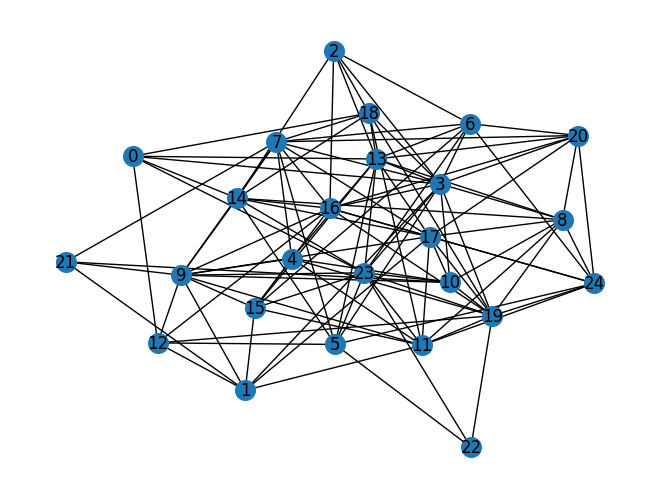

In [4]:
draw_graph(graph_sample, node_size=200, with_labels=True, width=1)

In [36]:

def pygraph_to_adj_matrix(graph: rx.PyGraph) -> np.ndarray:
    n = graph.num_nodes()
    adj_matrix = np.zeros((n, n), dtype=int)

    for i, j, in graph.edge_list():
        adj_matrix[i][j] = 1
        adj_matrix[j][i] = 1  # because it's undirected

    return adj_matrix

In [37]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        #paulis = ["I"] * 127
        #print(edge)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list

In [38]:
_PARITY = np.array([-1 if bin(i).count("1") % 2 else 1 for i in range(256)], dtype=np.complex128)


## Auxiliary function helping to calculate the cost for a given state (sample output)

def calculate_cost(state: int, observable: SparsePauliOp) -> complex:
    """Utility for the evaluation of the expectation value of a measured state."""
    packed_uint8 = np.packbits(observable.paulis.z, axis=1, bitorder="little")
    state_bytes = np.frombuffer(state.to_bytes(packed_uint8.shape[1], "little"), dtype=np.uint8)
    reduced = np.bitwise_xor.reduce(packed_uint8 & state_bytes, axis=1)
    return np.sum(observable.coeffs * _PARITY[reduced]).real

In [39]:
def brute_force_max_cut(adj_matrix):
    n = adj_matrix.shape[0]
    nodes = list(range(n))
    max_cut_value = 0
    best_partition = None

    # Try all possible partitions (excluding symmetric duplicates)
    for bits in itertools.product([0, 1], repeat=n):
        if all(b == 0 for b in bits) or all(b == 1 for b in bits):
            continue  # Skip trivial partitions

        cut_value = 0
        for i in range(n):
            for j in range(i+1, n):
                if bits[i] != bits[j] and adj_matrix[i, j] == 1:
                    cut_value += 1

        if cut_value > max_cut_value:
            max_cut_value = cut_value
            best_partition = bits

    return max_cut_value, best_partition

max_cut_value, best_partition = brute_force_max_cut(pygraph_to_adj_matrix(graph_sample))
list_p = list(best_partition)
list_p.reverse()

bitstring = ''.join(str(bit) for bit in list_p)

bit_int = int(bitstring, 2)
hamiltonian = SparsePauliOp.from_list(build_max_cut_paulis(graph_sample))

cost = calculate_cost(bit_int, hamiltonian)

file_path = os.path.join(folder_path, graphs_str[graph_index] + ".json")

# Prepare data in JSON format
data = [
    {"cut_value": max_cut_value, "partition": best_partition, "cost_value": cost}
]

# Write JSON to file
with open(file_path, "w") as f:
    json.dump(data, f, indent=4)